In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import wandb 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [2]:
SOS_token = 0
EOS_token = 1
MAX_LENGTH = 40
WANDB_NOTEBOOK_NAME = 'Assignment3'
WANDB_PROJECT_NAME = 'CS6910_A3'
WANDB_ENTITY = 'cs20b004'
model_number = 0
wandb.login()

class Lang:
    def __init__(self, name):
        self.name = name
        # self.word2index = {}
        # self.word2count = {}
        # self.index2word = {0: "SOS", 1: "EOS"}
        # self.n_words = 2  # Count SOS and EOS
        self.letter_index = {}
        self.letter_count = {}
        self.index_letter = {0: "SOS", 1: "EOS"}
        self.n_letters = 2  # Count SOS and EOS


    def add_word(self, word):
        # for word in sentence.split(' '):
        #     self.addWord(word)
        for letter in word:
            self.add_letter(letter)

    def add_letter(self, letter):
        # if word not in self.word2index:
        #     self.word2index[word] = self.n_words
        #     self.word2count[word] = 1
        #     self.index2word[self.n_words] = word
        #     self.n_words += 1
        # else:
        #     self.word2count[word] += 1
        if letter not in self.letter_index:
            self.letter_index[letter] = self.n_letters
            self.letter_count[letter] = 1
            self.index_letter[self.n_letters] = letter
            self.n_letters += 1
        else:
            self.letter_count[letter] += 1

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: cs20b004. Use `wandb login --relogin` to force relogin


In [3]:
def read_words(output_lang, type = 'train', reverse = False):
    lines = open('aksharantar_sampled/%s/%s_%s.csv' % (output_lang,output_lang,type), encoding='utf-8').read().strip().split('\n')
    pairs = [[s for s in l.split(',')] for l in lines]
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
    else:
        pairs = [list(p) for p in pairs]
    return pairs

def init_lang(lang1, lang2, type = 'train', reverse = False):
    pairs = read_words(lang2, type, reverse)
    input_lang = Lang(lang1)
    output_lang = Lang(lang2)
    char = 'a'
    for i in range(26):
        input_lang.add_letter(char)
        char = chr(ord(char) + 1)
    char = '\u0900'
    for i in range(128):
        output_lang.add_letter(char)
        char = chr(ord(char) + 1)
    # for pair in pairs:
    #     input_lang.add_word(pair[0])
    #     output_lang.add_word(pair[1])
    
    return input_lang, output_lang, pairs

In [4]:
pairs = read_words('mar',type = 'train')
for p in pairs:
    MAX_LENGTH = max(MAX_LENGTH, len(p[1]))
print("MAX_LENGTH: ", MAX_LENGTH)

MAX_LENGTH:  40


In [5]:
# def indexesFromSentence(lang, sentence):
#     return [lang.word2index[word] for word in sentence.split(' ')]
def word_to_index(lang, word):
    return [lang.letter_index[letter] for letter in word]


# def tensorFromSentence(lang, sentence):
#     indexes = indexesFromSentence(lang, sentence)
#     indexes.append(EOS_token)
#     return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def word_to_tensor(lang, word):
    indexes = word_to_index(lang, word)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


# def tensorsFromPair(pair):
#     input_tensor = tensorFromSentence(input_lang, pair[0])
#     target_tensor = tensorFromSentence(output_lang, pair[1])
#     return (input_tensor, target_tensor)

def pair_to_tensor(input_lang,output_lang, pair):
    input_tensor = word_to_tensor(input_lang, pair[0])
    target_tensor = word_to_tensor(output_lang, pair[1])
    return (input_tensor, target_tensor)


In [6]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, num_layers, type = 'gru', nonlinearity = 'tanh', dropout_p = 0.1, bidirectional = False):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding_size = embedding_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(input_size, embedding_size)
        self.dropout_p = dropout_p
        self.bidirectional = bidirectional
        self.dropout = nn.Dropout(self.dropout_p)
        self.type = type
        if self.type == 'gru':
            self.gru = nn.GRU(embedding_size, hidden_size, num_layers = num_layers, bidirectional = self.bidirectional)
        elif self.type == 'lstm':
            self.lstm = nn.LSTM(embedding_size, hidden_size, num_layers = num_layers, bidirectional = self.bidirectional)
        elif self.type == 'rnn':
            self.rnn = nn.RNN(embedding_size, hidden_size, num_layers = num_layers, bidirectional = self.bidirectional)

    def forward(self, input, hidden, cell):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        if self.type == 'gru':
            output, hidden = self.gru(output, hidden)
        elif self.type == 'lstm':
            output, (hidden, cell) = self.lstm(output, (hidden, cell))
        elif self.type == 'rnn':
            output, hidden = self.rnn(output, hidden)
        return output, hidden, cell

    def initHidden(self):
        return torch.zeros(self.num_layers , 1, self.hidden_size, device=device)
    
    def init_cell(self):
        return self.initHidden()

In [7]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, embedding_size, output_size, num_layers, nonlinearity = 'tanh', dropout_p = 0.1, type = 'gru', bidirectional = False):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding_size = embedding_size
        self.dropout_p = dropout_p
        self.embedding = nn.Embedding(output_size, embedding_size)
        # self.dropout = nn.Dropout(self.dropout_p)
        self.bidirectional = bidirectional
        self.num_layers = num_layers
        self.dropout = nn.Dropout(self.dropout_p)
        self.type = type
        if self.type == 'gru':
            self.gru = nn.GRU(embedding_size, hidden_size, num_layers = num_layers, bidirectional = self.bidirectional)
        elif self.type == 'lstm':
            self.lstm = nn.LSTM(embedding_size, hidden_size, num_layers = num_layers, bidirectional = self.bidirectional)
        elif self.type == 'rnn':
            self.rnn = nn.RNN(embedding_size, hidden_size, num_layers = num_layers, bidirectional = self.bidirectional)
            
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden, cell):
        output = self.embedding(input).view(1, 1, -1)
        output = self.dropout(output)
        output = F.relu(output)
        if self.type == 'gru':
            output, hidden = self.gru(output, hidden)
        elif self.type == 'lstm':
            output, (hidden, cell) = self.lstm(output, (hidden, cell))
        elif self.type == 'rnn':
            output, hidden = self.rnn(output, hidden)
        
        output = self.softmax(self.out(output[0]))
        return output, hidden, cell

    def initHidden(self):
        return torch.zeros(self.num_layers, 1, self.hidden_size, device=device)
    
        
    def init_cell(self):
        return self.initHidden()

In [8]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, embedding_size, output_size, num_layers, nonlinearity = 'tanh', dropout_p=0.1 , max_length=MAX_LENGTH, type = 'gru', bidirectional = False):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding_size = embedding_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length
        self.num_layers = num_layers
        self.embedding = nn.Embedding(self.output_size, self.embedding_size)
        self.attn = nn.Linear(self.hidden_size + self.embedding_size, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size + self.embedding_size, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.bidirectional = bidirectional
        self.type = type
        
        if self.type == 'gru':
            self.gru = nn.GRU(hidden_size, hidden_size, num_layers = num_layers, bidirectional = self.bidirectional)
        elif self.type == 'lstm':
            self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers = num_layers, bidirectional = self.bidirectional)
        elif self.type == 'rnn':
            self.rnn = nn.RNN(hidden_size, hidden_size, num_layers = num_layers, bidirectional = self.bidirectional)

        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, cell, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        if self.type == 'gru':
            output, hidden = self.gru(output, hidden)
        elif self.type == 'lstm':
            output, (hidden, cell) = self.lstm(output, (hidden, cell))
        elif self.type == 'rnn':
            output, hidden = self.rnn(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, cell, attn_weights

    def initHidden(self):
        return torch.zeros(self.num_layers, 1, self.hidden_size, device=device)
        
    def init_cell(self):
        return self.initHidden()

In [12]:
class Transliterator():
    def __init__(self, encoder_hp, decoder_hp, attn = True):
        self.encoder = EncoderRNN(
                        encoder_hp['input_size'],
                        encoder_hp['embedding_size'],
                        encoder_hp['hidden_size'], 
                        encoder_hp['num_layers'], 
                        type = encoder_hp['type'],
                        dropout_p= encoder_hp['dropout_p'],
                        bidirectional = encoder_hp['bidirectional']
                        ).to(device)
        self.attn = attn
        if attn:
            self.decoder = AttnDecoderRNN(
                            decoder_hp['hidden_size'], 
                            decoder_hp['embedding_size'],
                            decoder_hp['output_size'], 
                            decoder_hp['num_layers'], 
                            type = decoder_hp['type'],
                            dropout_p = decoder_hp['dropout_p'],
                            bidirectional = decoder_hp['bidirectional']
                            ).to(device)
        else:
            self.decoder = DecoderRNN(
                            decoder_hp['hidden_size'], 
                            decoder_hp['embedding_size'],
                            decoder_hp['output_size'], 
                            decoder_hp['num_layers'],  
                            type = decoder_hp['type'],
                            dropout_p = decoder_hp['dropout_p'],
                            bidirectional = decoder_hp['bidirectional']
                            ).to(device)

    def train(self, input_tensor, target_tensor, max_length=MAX_LENGTH):
        encoder_hidden = self.encoder.initHidden()
        encoder_cell = self.encoder.init_cell()

        self.encoder_optimizer.zero_grad()
        self.decoder_optimizer.zero_grad()

        input_length = input_tensor.size(0)
        target_length = target_tensor.size(0)

        encoder_outputs = torch.zeros(max_length, self.encoder.hidden_size, device=device)

        loss = 0

        for ei in range(input_length):
            encoder_output, encoder_hidden, encoder_cell = self.encoder(input_tensor[ei], encoder_hidden, encoder_cell)
            encoder_outputs[ei] = encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)
        decoder_hidden = encoder_hidden[encoder_hidden.shape[0] - 1].unsqueeze(0)
        decoder_cell = encoder_cell[encoder_cell.shape[0] - 1].unsqueeze(0)

        decoded_word = ''
        for i in range(self.decoder.num_layers - 1):
            decoder_hidden = torch.cat((decoder_hidden, encoder_hidden[encoder_hidden.shape[0] - 1].unsqueeze(0)), 0)
            decoder_cell = torch.cat((decoder_cell, encoder_cell[encoder_cell.shape[0] - 1].unsqueeze(0)), 0)

        use_teacher_forcing = True if random.random() < self.teacher_forcing_ratio else False
        # print(encoder_outputs.shape)
        if use_teacher_forcing:
            for di in range(target_length):
                if self.attn:
                    decoder_output, decoder_hidden, decoder_cell, decoder_attention = self.decoder(decoder_input, decoder_hidden, decoder_cell, encoder_outputs)
                else:
                    decoder_output, decoder_hidden, decoder_cell = self.decoder(decoder_input, decoder_hidden, decoder_cell)
                topv, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze().detach()  
                loss += self.criterion(decoder_output, target_tensor[di])
                decoded_word += self.output_lang.index_letter[topi.item()]
                decoder_input = target_tensor[di]
        else:
            for di in range(target_length):
                if self.attn:
                    decoder_output, decoder_hidden, decoder_cell, decoder_attention = self.decoder(decoder_input, decoder_hidden, decoder_cell, encoder_outputs)
                else:
                    decoder_output, decoder_hidden, decoder_cell = self.decoder(decoder_input, decoder_cell, decoder_hidden)
                topv, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze().detach()  
                loss += self.criterion(decoder_output, target_tensor[di])
                if decoder_input.item() == EOS_token:
                    break
                decoded_word += self.output_lang.index_letter[topi.item()]
                
        
        loss.backward()

        self.encoder_optimizer.step()
        self.decoder_optimizer.step()
        
        return loss.item() / target_length, decoded_word 
    
    def fit( self, train_io_pair, val_io_pair, input_lang, output_lang, n_epochs,optimizer = 'adam', criterion = nn.NLLLoss(), print_every=1000, learning_rate=0.0001, teacher_forcing_ratio = 0.5, use_wanb = False, model_name = 'model'):
        self.input_lang = input_lang
        self.output_lang = output_lang

        if(optimizer == 'adam'):
            self.encoder_optimizer = optim.Adam(self.encoder.parameters(), lr=learning_rate)
            self.decoder_optimizer = optim.Adam(self.decoder.parameters(), lr=learning_rate)
        elif(optimizer == 'sgd'):
            self.encoder_optimizer = optim.SGD(self.encoder.parameters(), lr=learning_rate)
            self.decoder_optimizer = optim.SGD(self.decoder.parameters(), lr=learning_rate)
            
        self.criterion = criterion
        self.learning_rate = learning_rate
        self.teacher_forcing_ratio = teacher_forcing_ratio
        self.n_epochs = n_epochs
        self.print_every = print_every
        
        self.all_losses = []
        self.total_loss = 0

        # for i in range(len(train_io_pair)):
        #     train_io_pair[i] = pair_to_tensor(train_io_pair[i])
        training_pairs = [pair_to_tensor(self.input_lang, self.output_lang, train_io_pair[i]) for i in range(len(train_io_pair))]
        train_accs = []
        val_accs = []
        for epc in range(1,n_epochs + 1):
            correct = 0
            for inp in range(len(train_io_pair)):
                input_tensor = training_pairs[inp][0]
                target_tensor = training_pairs[inp][1]
                loss, decoder_output = self.train(input_tensor, target_tensor)
                self.total_loss += loss
                self.all_losses.append(loss)
                if(decoder_output == train_io_pair[inp][1]):
                    correct += 1
            train_acc,train_ouput = self.eval(train_io_pair)
            train_accs.append(train_acc)
            val_acc,val_output = self.eval(val_io_pair)
            val_accs.append(val_acc)
            print("Epoch: ", epc, " Loss: ", self.total_loss / len(train_io_pair),
                  "Training Accuracy: ", train_acc,
                  "Validation Accuracy: ", val_acc)
            if(use_wanb):
                wandb.log({
                    "epoch" : epc,
                    "train_loss" : self.total_loss / len(train_io_pair),
                    "Training Accuracy": train_acc, 
                    "Validation Accuracy": val_acc
                    })
            self.total_loss = 0
            if epc >5 and val_acc < 0.3:
                break
            if len(val_accs) > 3 and val_accs[-1] < val_accs[-3]:
                break
            if len(train_accs) > 3 and train_accs[-1] < train_accs[-3]:
                break
        
        torch.save(self.encoder.state_dict(), f'Saved_models/Model_{model_name}val_acc_{int(val_accs[-1]*100)}encoder.pth')
        torch.save(self.decoder.state_dict(), f'Saved_models/Model_{model_name}val_acc_{int(val_accs[-1]*100)}decoder.pth')

    def eval(self, io_pairs):
        correct = 0
        results = []
        for i in range(len(io_pairs)):
            output, _ = self.predict(io_pairs[i][0])
            results.append(output)
            if output == io_pairs[i][1]:
                correct += 1
        return correct / len(io_pairs), results
    
    def predict(self, input_word, max_length=MAX_LENGTH):
        with torch.no_grad():
            input_tensor = word_to_tensor(self.input_lang, input_word)
            input_length = input_tensor.size()[0]
            encoder_hidden = self.encoder.initHidden()
            encoder_cell = self.encoder.init_cell()
            encoder_outputs = torch.zeros(max_length, self.encoder.hidden_size, device=device)

            for ei in range(input_length):
                encoder_output, encoder_hidden, encoder_cell = self.encoder(input_tensor[ei],
                                                        encoder_hidden, encoder_cell)
                encoder_outputs[ei] += encoder_output[0, 0]

            decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

            decoder_hidden = encoder_hidden[encoder_hidden.shape[0] - 1].unsqueeze(0)
            decoder_cell = encoder_cell[encoder_cell.shape[0] - 1].unsqueeze(0)

            decoded_word = ''
            for i in range(self.decoder.num_layers - 1):
                decoder_hidden = torch.cat((decoder_hidden, encoder_hidden[encoder_hidden.shape[0] - 1].unsqueeze(0)), 0)
                decoder_cell = torch.cat((decoder_cell, encoder_cell[encoder_cell.shape[0] - 1].unsqueeze(0)), 0)

            decoder_attentions = torch.zeros(max_length, max_length)

            for di in range(max_length):
                if self.attn:
                    decoder_output, decoder_hidden, decoder_cell, decoder_attention = self.decoder(
                    decoder_input, decoder_hidden, decoder_cell, encoder_outputs)
                    decoder_attentions[di] = decoder_attention.data
                else:
                    decoder_output, decoder_hidden, decoder_cell = self.decoder(
                    decoder_input, decoder_hidden, decoder_cell)
                topv, topi = decoder_output.data.topk(1)
                if topi.item() == EOS_token:
                    # decoded_words.append('<EOS>')
                    # decoded_word += '<EOS>'
                    break
                else:
                    # decoded_words.append(output_lang.letter_index[topi.item()])
                    decoded_word += self.output_lang.index_letter[topi.item()]
                    # print(output_lang.index_letter[topi.item()])

                decoder_input = topi.squeeze().detach()

            return decoded_word, decoder_attentions[:di + 1]


In [13]:
input_lang, output_lang, train_pairs = init_lang( 'eng','mar', type = 'train', reverse = False)
validation_pairs = read_words('mar', type = 'valid')
# print(input_lang.n_letters)
encoder_hp = {
    'input_size': input_lang.n_letters, 
    'embedding_size': 64, 
    'hidden_size': 512, 
    'num_layers': 2, 
    'dropout_p': 0.1,
    'type': 'gru',
    'bidirectional': False}
decoder_hp = {
    'hidden_size': 512, 
    'embedding_size': 64, 
    'output_size': output_lang.n_letters, 
    'num_layers': 2, 
    'dropout_p': 0.1,
    'type': 'lstm',
    'bidirectional': False}

model = Transliterator(encoder_hp=encoder_hp, decoder_hp=decoder_hp, attn = True)
# model_number +=1
model.fit(train_pairs[:1], validation_pairs[:1], input_lang, output_lang, optimizer='adam', n_epochs = 1, learning_rate = 0.0003, teacher_forcing_ratio = 0.5)

Epoch:  1  Loss:  4.873104095458984 Training Accuracy:  0.0 Validation Accuracy:  0.0


In [11]:
sweep_config = {
    'name' : 'Overfixing',
    'method': 'bayes', #grid, random
    'metric': {
        'name': 'Validation Accuracy',
        'goal': 'maximize'
    },
    'parameters': {
        'embedding_size': {
            'values': [128, 192, 256]   }, 
        'hidden_size': {
            'values': [192, 256]   },
        'encoder_num_layers': { 
            'values': [1,2, 3]   },
        'encoder_type': {'values' : ['lstm']},
        'decoder_num_layers': {
            'values': [1, 2, 3]   },
        'decoder_type': {'values' : ['lstm']},
        'learning_rate': {'values': [0.0006, 0.0005, 0.0003]},
        'teacher_forcing_ratio': {'values': [ 0.6, 0.7]},
        'optimizer' : {'values': ['adam']},
        'epochs' : { 'values' : [10]},
        'dropout_p' : {'values' : [0.0, 0.2]},
        'bidirectional' : {'values' : [False]}
    }
}

best_config = {
    'name' : 'attention_testing',
    'method': 'grid', #grid, random
    'metric': {
        'name': 'Validation Accuracy',
        'goal': 'maximize'
    },
    'parameters': {
        'embedding_size': 
            {'value': 64},
        'hidden_size':
            {'value': 384},
        'encoder_num_layers':
            {'value': 2},
        'encoder_type':
            {'value' : 'lstm'},
        'decoder_num_layers':
            {'value': 2},
        'decoder_type':
            {'value' : 'lstm'},
        'learning_rate':    
            {'value': 0.0003},
        'teacher_forcing_ratio':
            {'value': 0.7},
        'optimizer' :
            {'value': 'adam'},
        'epochs' :
            {'value' : 10},
        'dropout_p' :
            {'value' : 0.0},
        'bidirectional' :
            {'value' : False}
    }
}

# sweep_id = wandb.sweep(sweep_config, project="CS6910_Assignment3")
sweep_id = wandb.sweep(sweep=best_config, project="CS6910_Assignment3")

def train():
    config_defaults = {
        'hidden_size': 256,
        'encoder_num_layers': 1,
        'encoder_type': 'gru',
        'decoder_num_layers': 1,
        'decoder_type': 'gru',
        'learning_rate': 0.0001,
        'teacher_forcing_ratio': 0.5,
        'optimizer' : 'adam',
        'epochs' : 5,
        'dropout_p' : 0.1,
        'bidirectional' : False
    }

    run = wandb.init()
    config = wandb.config
    name_str = f"nle_{wandb.config['encoder_num_layers']}_nld_{wandb.config['decoder_num_layers']}_lr_{wandb.config['learning_rate']}_eu_{wandb.config['encoder_type']}_du_{wandb.config['decoder_type']}"
    wandb.run.name = name_str
    model = Transliterator(
        encoder_hp={
            'input_size': input_lang.n_letters,
            'embedding_size' : config.embedding_size, 
            'hidden_size': config.hidden_size, 
            'num_layers': config.encoder_num_layers, 
            'type': config.encoder_type,
            'dropout_p' : config.dropout_p,
            'bidirectional' : config.bidirectional
            }, 
        decoder_hp={
            'hidden_size': config.hidden_size, 
            'embedding_size': config.embedding_size,
            'output_size': output_lang.n_letters, 
            'num_layers': config.decoder_num_layers, 
            'type': config.decoder_type,
            'dropout_p' : config.dropout_p,
            'bidirectional' : config.bidirectional
            }, 
        attn = True)
    model.fit(train_pairs, validation_pairs, input_lang, output_lang, n_epochs = config.epochs, learning_rate = config.learning_rate, teacher_forcing_ratio = config.teacher_forcing_ratio, use_wanb = True, model_name = "Attn_on_best")
    run.finish()

wandb.agent(sweep_id, train, count=2, project="CS6910_Assignment3", entity="cs20b004")
wandb.finish()


Create sweep with ID: yfqa6cy6
Sweep URL: https://wandb.ai/cs20b004/CS6910_Assignment3/sweeps/yfqa6cy6


wandb: Agent Starting Run: hj9ljras with config:
wandb: 	bidirectional: False
wandb: 	decoder_num_layers: 2
wandb: 	decoder_type: lstm
wandb: 	dropout_p: 0
wandb: 	embedding_size: 64
wandb: 	encoder_num_layers: 2
wandb: 	encoder_type: lstm
wandb: 	epochs: 10
wandb: 	hidden_size: 384
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: adam
wandb: 	teacher_forcing_ratio: 0.7
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch:  1  Loss:  1.2866709969610728 Training Accuracy:  0.26662109375 Validation Accuracy:  0.265380859375
Epoch:  2  Loss:  0.6021577574973235 Training Accuracy:  0.408046875 Validation Accuracy:  0.3525390625
Epoch:  3  Loss:  0.4685771653504404 Training Accuracy:  0.499453125 Validation Accuracy:  0.38671875
Epoch:  4  Loss:  0.3911346473431443 Training Accuracy:  0.57654296875 Validation Accuracy:  0.42236328125
Epoch:  5  Loss:  0.32988921786571174 Training Accuracy:  0.63494140625 Validation Accuracy:  0.417724609375
Epoch:  6  Loss:  0.28371943828453905 Training Accuracy:  0.674921875 Validation Accuracy:  0.4248046875
Epoch:  7  Loss:  0.24702618074901042 Training Accuracy:  0.715 Validation Accuracy:  0.433837890625
Epoch:  8  Loss:  0.22001459658824818 Training Accuracy:  0.738046875 Validation Accuracy:  0.4306640625
Epoch:  9  Loss:  0.19929555809721755 Training Accuracy:  0.759296875 Validation Accuracy:  0.435546875
Epoch:  10  Loss:  0.17755590599565152 Training Accurac

Training Accuracy,▁▃▄▅▆▇▇▇██
Validation Accuracy,▁▅▆▇▇█████
epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▄▃▂▂▂▁▁▁▁
Training Accuracy,0.78436
Validation Accuracy,0.43262
epoch,10
train_loss,0.17756


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


In [12]:
encoder_hp = {
    'input_size': input_lang.n_letters,
    'embedding_size' : 64,
    'hidden_size': 384,
    'num_layers': 1,
    'type': 'lstm',
    'dropout_p' : 0.0,
    bidirectional' : False}
decoder_hp = {
    'hidden_size': 384,
    'embedding_size': 64,
    'output_size': output_lang.n_letters,
    'num_layers': 1,
    'type': 'gru'}
model = Transliterator(encoder_hp=encoder_hp, decoder_hp=decoder_hp, attn = False)
model.encoder.load_state_dict(torch.load('Saved_models/Best_encoder.pth'))
model.decoder.load_state_dict(torch.load('Saved_models/Best_decoder.pth'))
model.input_lang = input_lang
model.output_lang = output_lang


KeyError: 'dropout_p'

In [14]:
encoder_hp_1= {
    'input_size': input_lang.n_letters,
    'embedding_size' : 64,
    'hidden_size': 384,
    'num_layers': 2,
    'type': 'lstm',
    'dropout_p' : 0,
    'bidirectional' : False
    }
decoder_hp_1 = {
    'hidden_size': 384,
    'embedding_size': 64,
    'output_size': output_lang.n_letters,
    'num_layers': 2,
    'dropout_p' : 0,
    'bidirectional' : False,
    'type': 'lstm'}

best_m = Transliterator(encoder_hp=encoder_hp_1, decoder_hp=decoder_hp_1, attn = False)
best_m.encoder.load_state_dict(torch.load('Saved_models/val_acc_44encoder.pth'))
best_m.decoder.load_state_dict(torch.load('Saved_models/val_acc_44decoder.pth'))
best_m.input_lang = input_lang
best_m.output_lang = output_lang



In [60]:
best_m_attn = Transliterator(encoder_hp=encoder_hp_1, decoder_hp=decoder_hp_1, attn = True)
best_m_attn.encoder.load_state_dict(torch.load('Saved_models/Model_Attn_on_bestval_acc_43encoder.pth'))
best_m_attn.decoder.load_state_dict(torch.load('Saved_models/Model_Attn_on_bestval_acc_43decoder.pth'))
best_m_attn.input_lang = input_lang
best_m_attn.output_lang = output_lang

In [61]:
test_pairs = read_words('mar', type = 'test')
# acc, output_test = best_m.eval(test_pairs)
#store in csv original and predicted
acc_attn,output_test_attn = best_m_attn.eval(test_pairs)


In [62]:
print(acc_attn)


0.375732421875


In [63]:
import pandas as pd
df = pd.DataFrame(list(zip([p[0] for p in test_pairs],[p[1] for p in test_pairs], output_test_attn)), columns = ['Original','Translated', 'Predicted'])
df.to_csv('predictions_attention.csv', index = False)

In [99]:
test_inputs = [
'heetler',
'kaushik',
'bombay',
'loid',
'shikshanvishayak',
'purushottam',
'shrivas',
'palale',
'baabhlichi',
'pitali']


attn_outputs = []
attn_heatmaps = []
for inp in test_inputs:
    output, _ = best_m_attn.predict(inp)
    attn_outputs.append(output)
    attn_heatmaps.append(_)




In [107]:
import numpy as np
import matplotlib.font_manager as fm
def plot_attention_heatmap(word,translated_word,attn_heatmap, ax,i, font_path="Lohit-Devanagari.ttf"):

    input_word_len = len(word)
    output_word_len = len(translated_word)

    ax.imshow(attn_heatmap[:, :input_word_len])

    font_prop = fm.FontProperties(fname=font_path, size=18)

    ax.set_xticks(np.arange(input_word_len))
    ax.set_yticks(np.arange(output_word_len))

    ax.set_xticklabels(list(word))
    ax.set_yticklabels(list(translated_word), fontproperties=font_prop)
    ax.set_xlabel("Input Word")
    ax.set_ylabel("Translated Word")


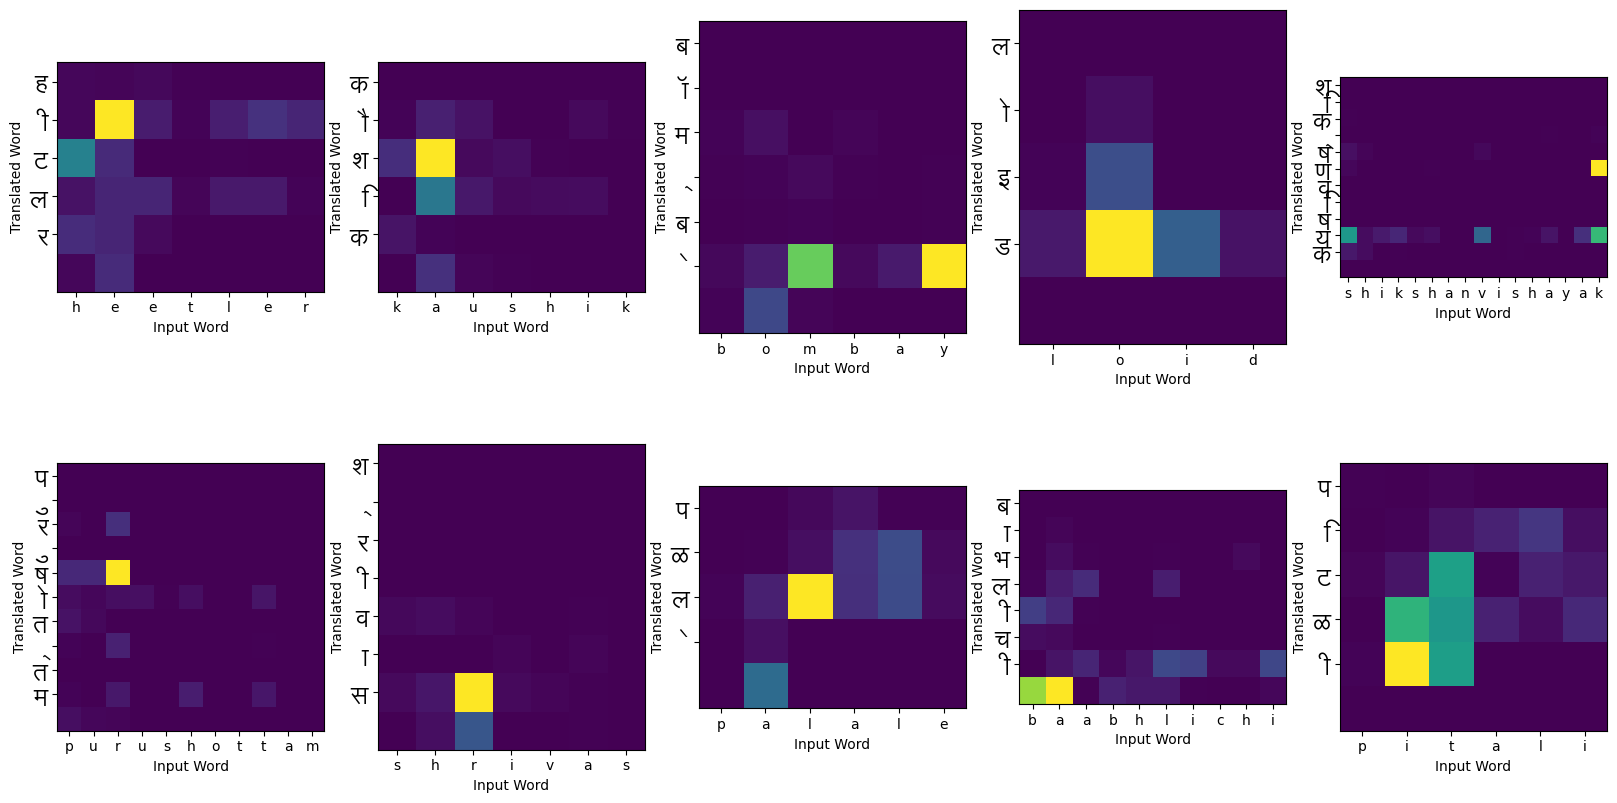

In [115]:
import matplotlib.pyplot as plt
#get 1 images and plot
fig, ax = plt.subplots(2, 5, figsize=(20, 10))

for i in range(2):
    for j in range(5):
        plot_attention_heatmap(test_inputs[i*5 + j],attn_outputs[i*5 + j],attn_heatmaps[i*5 + j], ax[i][j], str(i*5 + j))

# for i in range(10):
# # plot_attention_heatmap(test_inputs[0],attn_outputs[0],attn_heatmaps[0], ax, 0)
#   plot_attention_heatmap(test_inputs[i],attn_outputs[i],attn_heatmaps[i], ax[i], str(i))  

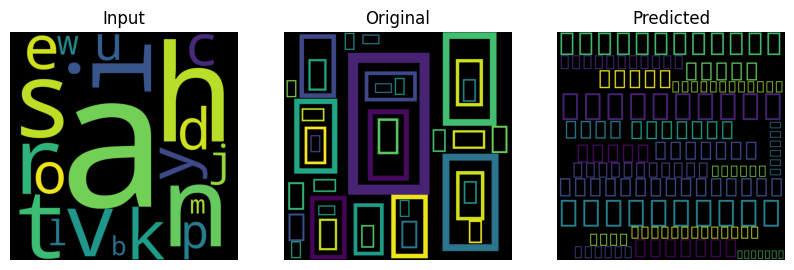

In [58]:
#use worldcloud to show most frequent words in the dataset
from wordcloud import WordCloud
from collections import Counter
#use confusion matrix to show the most frequent errors
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
#show both the original and predicted word
random_pairs = random.sample(test_pairs, 20)
in_english = [p[0] for p in random_pairs]
original = [p[1] for p in random_pairs]

in_english = Counter([i for p in random_pairs for i in p[0]])
original = Counter([i for p in random_pairs for i in p[1]])
predicted = Counter([best_m.predict(p[0])[0] for p in random_pairs])


# predicted = [best_m.predict(p[0]) for p in random_pairs]


wordcloud = WordCloud(width = 800, height = 800, random_state=1).generate_from_frequencies(in_english)
wordcloud1 = WordCloud(width = 800, height = 800, random_state=1).generate_from_frequencies(original)
wordcloud2 = WordCloud(width = 800, height = 800, random_state=1).generate_from_frequencies(predicted)


fig, axs = plt.subplots(1,3, figsize = (10,10))
axs[0].imshow(wordcloud)
axs[0].axis("off")
axs[0].set_title("Input")
axs[1].imshow(wordcloud1)
axs[1].axis("off")
axs[1].set_title("Original")
axs[2].imshow(wordcloud2)
axs[2].axis("off")
axs[2].set_title("Predicted")
# plt.savefig('wordcloud.png')
plt.show()